# <font color='blue'><b> Edge detection </b></font>


In [22]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import plotly.express as px      
import plotly.graph_objects as go 
import math
from plotly.subplots import make_subplots  
from skimage.io import imread
from skimage.color import rgb2gray


<font color="blue">Defining multiplotting and plot orientations mask</font>

In [23]:
def multiPlots(images, titles= [], nCols = 2):

  '''multiPlots funtion allows to plot a list of images organized on nCols, with possible titles'''
  
  plt.gray() 
  nImg =len(images)
  nRows = math.ceil(nImg/nCols) 
  f = plt.figure(figsize=(10,4*nRows))

  for n, image in enumerate(images): 
    row = int(n/nCols)+1
    col = n%nCols+1
    ax = f.add_subplot(nRows, nCols, n+1)
    ax.imshow(image, cmap='gray')   
    plt.axis('off')
    if titles:
      plt.title(titles[n]) 

def plot_orientationsMASK (theta, magnitude, perc=95):
    
    '''This function plot the theta corresponding to the strongest magnitude values
        INPUT: 
            - theta: orientation maps
            - magnitude: magnitude of the gradient
            - percentile: percentile of the strongest magnitude'''

    image_map = np.zeros((theta.shape[0], theta.shape[1], 3), dtype=np.int16)

    #1. Determine the threshold as a certain percentile of the magnitude
    TH =  np.percentile(magnitude, perc) 

    #2. Clean the theta and mag maps accordingly
    theta[magnitude < TH] = -1;
 
    # Define RGB colours
    red = np.array([255, 0, 0])
    cyan = np.array([0, 255, 255])
    green = np.array([0, 255, 0])
    yellow = np.array([255, 255, 0])

    # Set colours corresponding to angles
    for i in range(0, image_map.shape[0]):
        for j in range(0, image_map.shape[1]):
            if theta[i][j] < 90.0 and theta[i][j] >0:  # JUST EXCLUDE THE NEGATIVE VALUES FROM THIS CASE, 
                                                   # LEAVING THEM TO ZERO AS IN THE INITIALIZATION
                image_map[i, j, :] = red
            elif theta[i][j] >= 90.0 and theta[i][j] < 180.0:
                image_map[i, j, :] = cyan
            elif theta[i][j] >= 180.0 and theta[i][j] < 270.0:
                image_map[i, j, :] = green
            elif theta[i][j] >= 270.0 and theta[i][j] < 360.0:
                image_map[i, j, :] = yellow

    # Display gradient orientation
    f, ax1 = plt.subplots(1, 1, figsize=(10,5))

    ax1.set_title('gradient orientation')
    ax1.imshow(image_map)
    return image_map

<font color="blue">Load an Image and convert it into gray values</font>

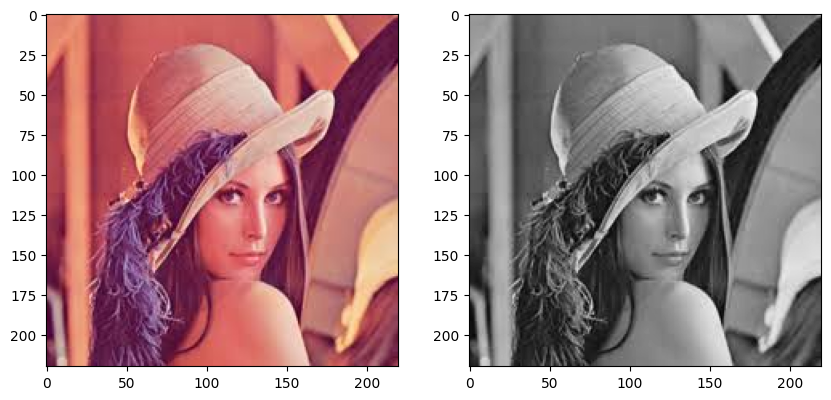

In [24]:
# load an example image 
img = imread('lena.jpg')

# show image (RGB and Gray)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img)
grayImg = rgb2gray(img)
 
plt.subplot(122)
plt.imshow(grayImg, cmap='gray')
plt.show()
#print(grayImg.dtype)

<font color="blue">Gradient with Sobel operator</font>

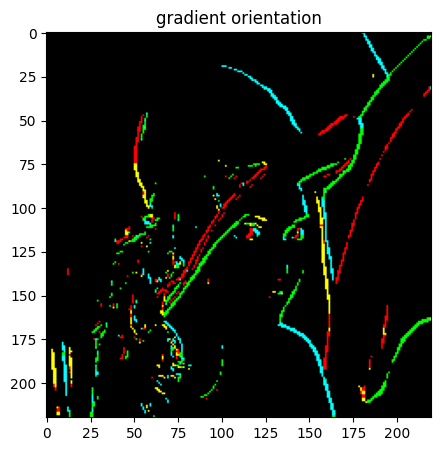

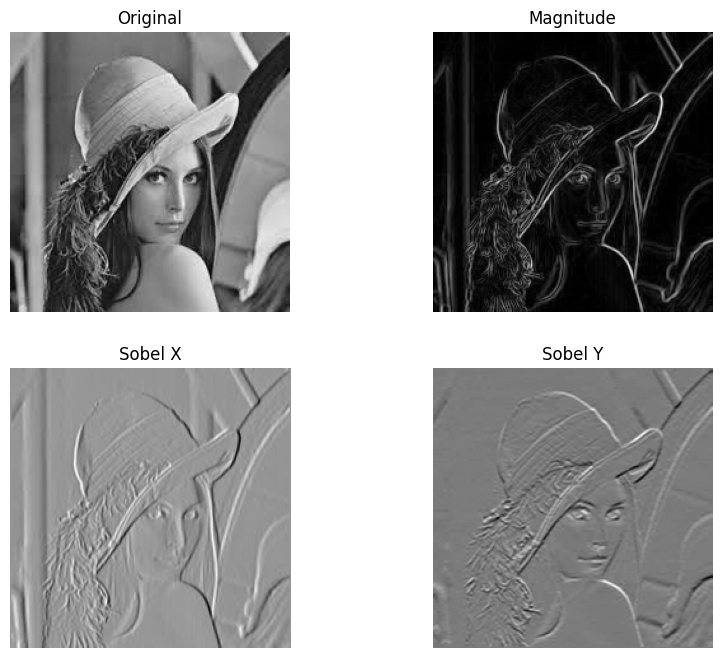

In [25]:
# SOBEL
sobelx = cv2.Sobel(grayImg, -1,1,0) #last 2 parameters: x_order and y_order
sobely = cv2.Sobel(grayImg, -1,0,1)

mag = cv2.magnitude(sobelx, sobely)
theta = cv2.phase(np.array(sobelx), np.array(sobely), angleInDegrees=True)

theta_map = plot_orientationsMASK(theta, mag, 95) 
multiPlots([grayImg, mag, sobelx, sobely ], ['Original', 'Magnitude','Sobel X', 'Sobel Y'])
  

<font color="blue">...Or Edge detection with built in Skimage</font>

<Figure size 640x480 with 0 Axes>

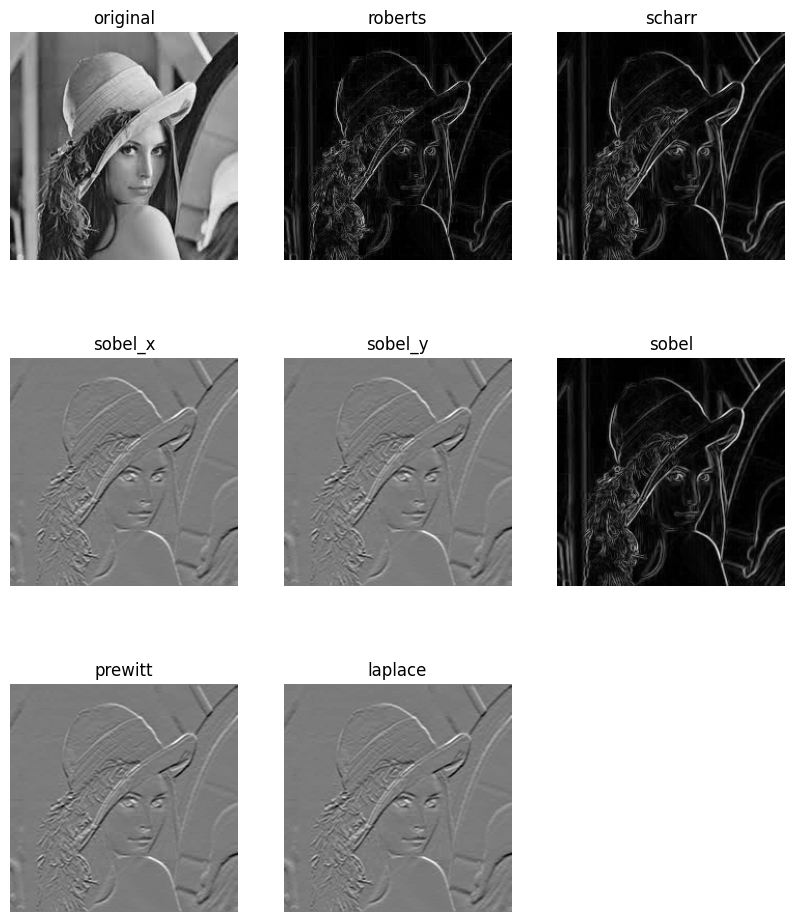

In [26]:
from skimage import filters, feature, img_as_float

plt.gray()
images = []
titles = []

images.append(grayImg)
titles.append('original')


rob = filters.roberts(grayImg)
images.append(rob)
titles.append('roberts')

sch = filters.scharr(grayImg)
images.append(sch)
titles.append('scharr')

sob_x = filters.sobel_h(grayImg)
images.append(sob_x)
titles.append('sobel_x') 

sob_y = filters.sobel_v(grayImg)
images.append(sob_x)
titles.append('sobel_y') 

sob = filters.sobel(grayImg)
images.append(sob)
titles.append('sobel') 

prew = filters.prewitt(grayImg)
images.append(sob_x)
titles.append('prewitt')

lap = filters.laplace(grayImg)
images.append(sob_x)
titles.append('laplace')

multiPlots(images, titles, 3)

# <font color="blue"><b>Figure-ground perception</b></font>

To separate the figure from the background we use k-means clustering algorithm which consists in labeling each pixel according to which k-eith center it is nearest to. 
We can then separate the figure labels from the background labels.

In [27]:
from skimage.color import rgb2luv, luv2rgb
from skimage import img_as_float, img_as_ubyte
from skimage import color, measure
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from itertools import cycle

<font color="blue">K-means on RGB image</font>

In [28]:
n_colors = 2 # Specify the desired number of clusters


# Load the RGB image
img = imread('flower.jpg') 
 
# Reshape the image into an RGB pixel matrix
w, h, c = img.shape
 
image_array = img.reshape((-1,3))
print(f'image_array shape: {image_array.shape}')

# Shuffle the pixels (useful for more stable results)
image_array_sample = shuffle(image_array, random_state=0)

# Create a KMeans object
kmeans = KMeans(n_clusters=n_colors, n_init='auto')

# Perform clustering on the image pixels
kmeans.fit(image_array_sample)

# Extract cluster labels for each pixel
labels = kmeans.predict(image_array)
labels_unique =  np.unique(labels)
print(f'labels dimensions: {labels.shape}')

# Extract cluster centroids
cluster_centers = kmeans.cluster_centers_.astype(np.uint8)
print(f'cluster_centers dimensions: {cluster_centers.shape}') 

# Create an image with the colors of the centroids
clustered_image = cluster_centers[labels].reshape(w, h, c)
print(f'clustered_image dimensions: {clustered_image.shape}') 


image_array shape: (76800, 3)
labels dimensions: (76800,)
cluster_centers dimensions: (2, 3)
clustered_image dimensions: (240, 320, 3)


<font color="blue">K-means on Luv image</font>

(76800, 2)


<Figure size 640x480 with 0 Axes>

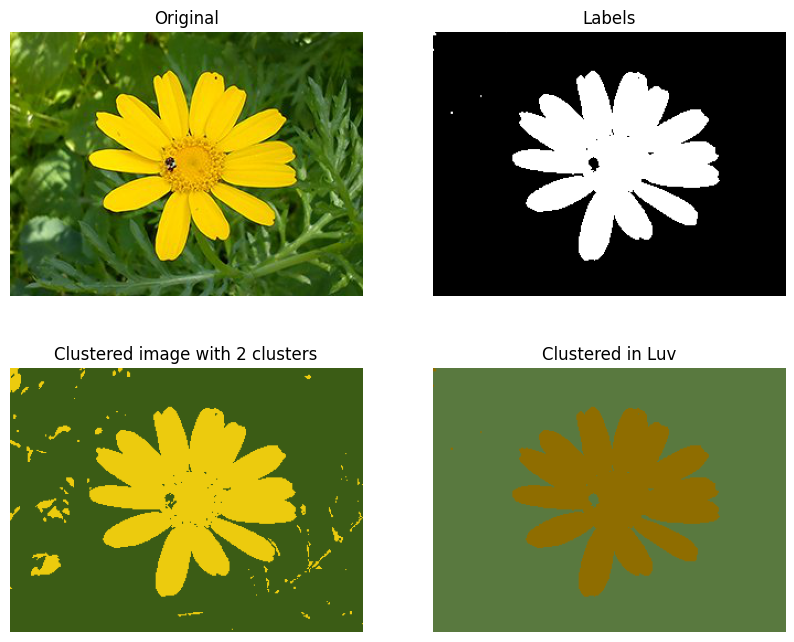

In [29]:
# compute the k-mean (k=2) on the uv channels, 

LuvImg = rgb2luv(img)
image_array = LuvImg[:, :, 1:3].reshape(-1, 2)
 
print(image_array.shape) #CHECK POINT. we should have: (h*w , 2)
image_array = np.float32(image_array); #cast 'z' to float with 32 bit 

image_array_sample = shuffle(image_array, random_state=0)

# Create a KMeans object
kmeans = KMeans(n_clusters=n_colors, n_init='auto')

# Perform clustering on the image pixels
kmeans.fit(image_array_sample)

# Extract cluster labels for each pixel
labels = kmeans.predict(image_array)
labels2d = labels.reshape(w,h) 
#plt.hist(labels2d.flatten(), bins=100, range=(0, 1)) #CHECK POINT

# Extract cluster centroids
cluster_centers = kmeans.cluster_centers_  

# Now convert back into uint8, and make original image
res = cluster_centers[labels]
res2 = res.reshape((w,h,2)) #here we have the u and v values for each pixel

#convert to a Luv first, and then to RGB for visualization
outLuv  = np.zeros_like(img, dtype=float)
outLuv [:,:,0]= np.mean(LuvImg[:,:,0])
outLuv[:, :, 1:3] = res2

outRGB = luv2rgb(outLuv) 
 
multiPlots([img, labels2d, clustered_image, outRGB], ['Original', 'Labels',f'Clustered image with {len(labels_unique)} clusters', 'Clustered in Luv'])

<font color="blue">Connected regions</font>

Num connected regions: 6


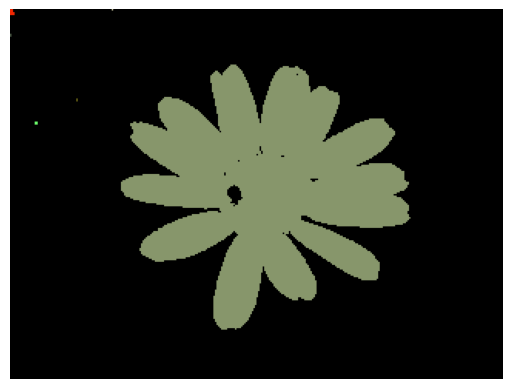

In [30]:
h,w =  labels2d.shape
result_mask = labels2d.astype(bool) 

# labeling of connected regions 
labeled_image, num_labels = measure.label(result_mask, connectivity=2, return_num=True)
print(f"Num connected regions: {num_labels}")

# Create a color palette to label each region.
label_colors = np.random.randint(0, 256, size=(num_labels, 3))

# Create a color-coded image based on the labels
colored_image = np.zeros((h,w,3), dtype=np.uint8)
for label in range(1, num_labels + 1):
    colored_image[labeled_image == label] = label_colors[label - 1]

# Show the color-coded image
plt.imshow(colored_image)
plt.axis('off')
plt.show()


<font color="blue">Find largest region</font>

In [31]:
def find_largest_area(labeled_image):
    
    # Extract the region properties 
    region_props = measure.regionprops(labeled_image) # https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops

    # Find the largest connected region
    max_area = 0
    largest_region = None

    for region in region_props:
        if region.area > max_area:
            max_area = region.area
            largest_region = region

    largest_region_mask = (labeled_image == largest_region.label)
    return largest_region_mask

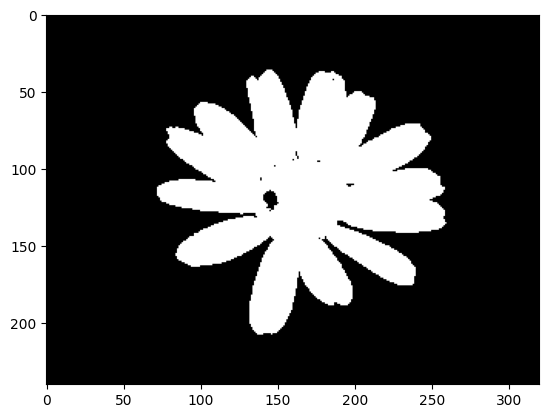

In [32]:
result_mask = labels2d.astype(np.uint8) 
img_foreground= img.copy()

# Label the connected regions 
labeled_image, num_labels = measure.label(result_mask, connectivity=2, return_num=True)

image_largest_region = find_largest_area(labeled_image)
plt.imshow(image_largest_region)

<font color="blue">Background to black</font>

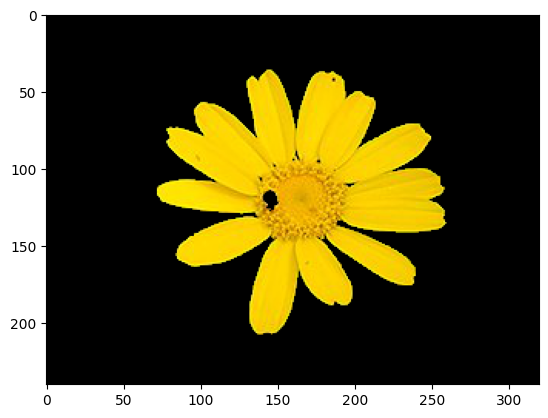

In [33]:
img_foreground[~image_largest_region] = 0
 
plt.imshow(img_foreground)